# Autoencoders

In this example we will create an autoencoder using the `DenseMML` layers available in Keras-MML.

The dataset we will use is the [Fashion MNIST dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist). It is intended as a drop-in replacement for the standard [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), and shares the same image size and structure of training and testing splits.

<center>
    <img alt="Fashion MNIST Dataset Cover" style="width: 75%" src="https://storage.googleapis.com/kaggle-datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-cover.png">
</center>

:::{important}
We will be using some plotting utilities for this notebook. Run the command below to install them, then reload the kernel.
:::

In [1]:
%pip install matplotlib~=3.9.0 seaborn~=0.13.2

Note: you may need to restart the kernel to use updated packages.


## Setup

First, let's prepare the imports.

In [2]:
import keras

2024-06-19 08:43:59.890758: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 08:43:59.893358: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 08:43:59.925210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 08:44:00.681677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Define constants relating to the data.

In [3]:
NUM_CLASSES = 10        # 10 distinct classes, 0 to 9
INPUT_SHAPE = (28, 28)  # 28 x 28 greyscale images

Load the data from the `fashion_mnist` dataset. We don't actually need the labels in this case.

In [4]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)

Perform some preprocessing.

In [5]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

Check the shapes of the arrays that we have so far.

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Let's look at some of the data.

In [7]:
import matplotlib.pyplot as plt


def display_images(images):
    n = len(images)
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title(f"Index {i}")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

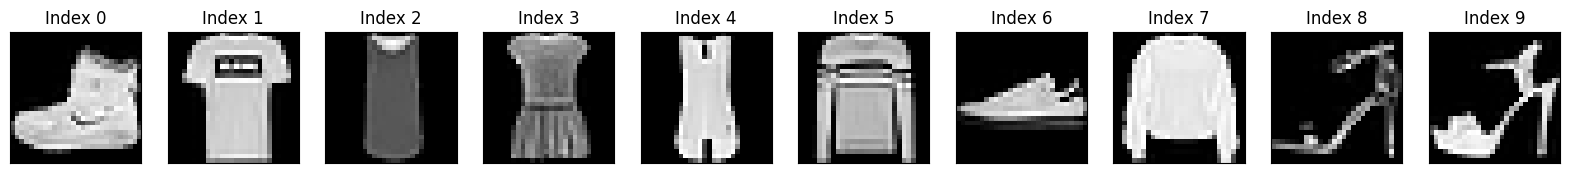

In [8]:
display_images(x_train[:10])

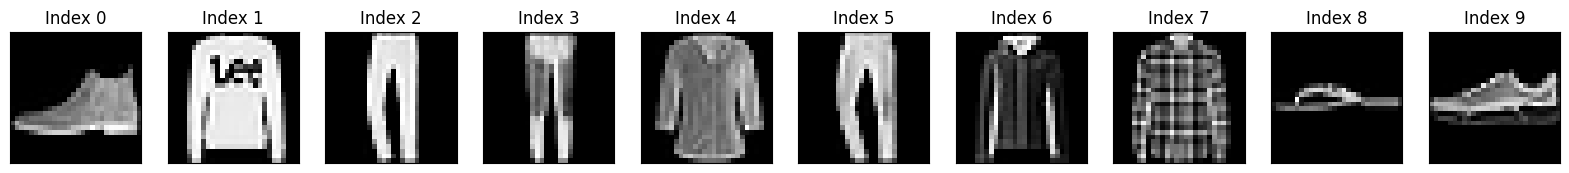

In [9]:
display_images(x_test[:10])

## Creating the Autoencoder

Like with most other examples, the architecture for the model is simple, just that the we replace `Dense` layers with `DenseMML`.

Of course, we need to import `keras_mml` first.

In [10]:
import keras_mml

Now we define the encoder and decoder halves of the model.

In [11]:
def create_encoder():
    encoder = keras.Sequential(name="Encoder")
    encoder.add(keras.Input((28, 28), name="encoder_input"))
    encoder.add(keras.layers.Flatten())
    encoder.add(keras_mml.layers.DenseMML(512, activation="relu"))
    encoder.add(keras_mml.layers.DenseMML(256, activation="relu"))
    encoder.add(keras_mml.layers.DenseMML(128, activation="relu", name="encoder_output"))
    return encoder


def create_decoder():
    decoder = keras.Sequential(name="Decoder")
    decoder.add(keras.Input((128,), name="decoder_input"))
    decoder.add(keras_mml.layers.DenseMML(256, activation="relu"))
    decoder.add(keras_mml.layers.DenseMML(512, activation="relu"))
    decoder.add(keras.layers.Dense(784, activation="sigmoid"))  # We need un-quantized outputs here
    decoder.add(keras.layers.Reshape((28, 28), name="decoder_output"))
    return decoder


def create_model(encoder, decoder):
    model = keras.Sequential(name="Autoencoder")
    model.add(keras.layers.Input((28, 28), name="input"))
    model.add(encoder)
    model.add(decoder)

    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )

    return model


model = create_model(create_encoder(), create_decoder())
model.summary(expand_nested=True)

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder (Sequential)            │ (None, 128)            │       565,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ flatten (Flatten)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_mml (DenseMML)       │ (None, 512)            │       401,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_mml_1 (DenseMML)     │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ encoder_output (DenseMML)  │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 28, 28)         │       566,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_mml_2 (DenseMML)     │ (None, 256)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_mml_3 (DenseMML)     │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense (Dense)              │ (None, 784)            │       402,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ decoder_output (Reshape)   │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,131,280 (4.32 MB)

 Trainable params: 1,131,280 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

With the model defined, we can train it. We will halt training of the model if the validation loss does not improve drastically.

In [12]:
model.fit(
    x_train, x_train,  # Input should match output
    validation_split=0.1,
    batch_size=256,
    epochs=200,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1),
    ]
)

Epoch 1/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1618 - mae: 0.3739 - val_loss: 0.1193 - val_mae: 0.3227
Epoch 2/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1058 - mae: 0.2992 - val_loss: 0.0830 - val_mae: 0.2483
Epoch 3/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0795 - mae: 0.2395 - val_loss: 0.0719 - val_mae: 0.2195
Epoch 4/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0692 - mae: 0.2137 - val_loss: 0.0631 - val_mae: 0.1995
Epoch 5/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0606 - mae: 0.1945 - val_loss: 0.0557 - val_mae: 0.1830
Epoch 6/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0536 - mae: 0.1785 - val_loss: 0.0501 - val_mae: 0.1694
Epoch 7/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0485 - mae: 0.1657 - val_loss: 0.0459 - val_mae: 0.1587
Epoch 8/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0446 - mae: 0.1556 - val_loss: 0.0427 - val_mae: 0.1502
Epoch 9/200
211/211 ━━━━━━━━━━━━━━━━━━━━

How well did the model do?

In [13]:
test_mse, test_mae = model.evaluate(x_test, x_test)
print(f"Testing MSE: {test_mse:.5f}")
print(f"Testing MAE: {test_mae:.5f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - mae: 0.0922
Testing MSE: 0.02319
Testing MAE: 0.09256


## Experiments with the Trained Model

Let's grab one of the testing samples.

In [14]:
testing_sample = x_test[1234]

What does it look like?

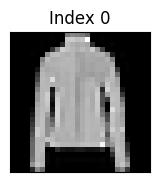

In [15]:
display_images([testing_sample])

Let's pass it through the autoencoder and see its output.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


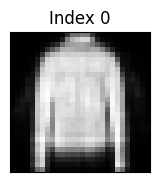

In [16]:
transformed_testing_sample = model.predict(testing_sample.reshape((1, 28, 28)))[0]
display_images([transformed_testing_sample])

Let's run it on a whole range of samples at once.

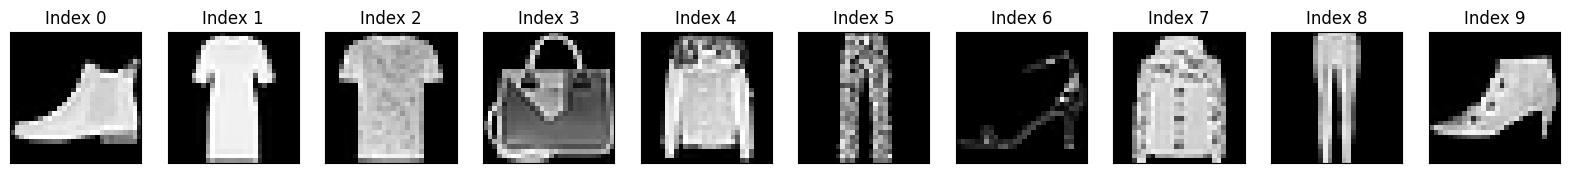

In [17]:
testing_samples = x_test[123:123+10]
display_images(testing_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


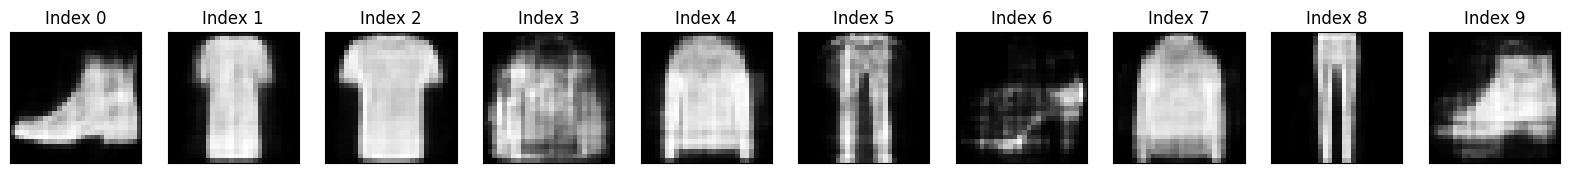

In [18]:
transformed_testing_samples = model.predict(testing_samples.reshape((10, 28, 28)))
display_images(transformed_testing_samples)

In this example, we have seen how `DenseMML` acts as a suitable replacement for `Dense` layers in a traditional autoencoder. They seem to perform decently well in retaining the important information within their hidden layers.